In [3]:
import tqdm
import cv2
import splitfolders
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shutil
import glob
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import HTML

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import ResNet50

import tensorflow
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow
import ssl
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras import optimizers 

from keras import layers 
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from skimage import transform 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
from keras.preprocessing import image

In [ ]:
# preform train test split on dataset 

input_dataset_directory = '/Volumes/My Passport/Dataset/'
output_dataset_directory = '/Volumes/My Passport/train_test_split/'

splitfolders.ratio(
    input_dataset_directory, 
    output=output_dataset_directory, 
    seed=21,  # replicate the "randomness" of split using this seed 
    ratio=(0.8, 0.2), 
    group_prefix=None
)

In [7]:
# Define Constants 

FAST_RUN = False 
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size = 15
total_train = 3000
total_test = 11988

In [3]:
# image preprocessing
 
TRAIN_PATH = '/Volumes/My Passport/train_test_split/train'
TEST_PATH = '/Volumes/My Passport/train_test_split/val'

# apply image augmentations to Training set 
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
) 

# apply image augmentations to Test set 
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Creating the Training set
proccessed_training_set = train_datagen.flow_from_directory(TRAIN_PATH,
                                                 target_size = IMAGE_SIZE,
                                                 class_mode = 'categorical',
                                                 batch_size = 15)
                                                 
# Creating the Test set
proccessed_test_set = test_datagen.flow_from_directory(TEST_PATH,
                                            target_size = IMAGE_SIZE,
                                            class_mode = 'categorical',
                                            batch_size = 15)            

Found 11988 images belonging to 4 classes.
Found 3000 images belonging to 4 classes.


In [4]:
# Build CNN Architechture 

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid')) # 4 output classes, activation for multiclass is 'sigmoid'

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      2

In [5]:
# Early stopping monitors the loss minimization at the end of every epoch. 
# If the loss is no longer decreasing, and this continues through 10 epochs (patience=10), 
# training is stopped early. 
earlystop = EarlyStopping(patience=10)

In [6]:
# Reduces learing rate when accuracy metric has stopped improving. 
# Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
# This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, 
# the learning rate is reduced.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [8]:
# Applies specified callbacks in model.fit 
# Look into more callbacks https://keras.io/api/callbacks/model_checkpoint/
callbacks = [earlystop, learning_rate_reduction]

In [10]:
# Train model
epochs=3 if FAST_RUN else 50
history = model.fit(
    proccessed_training_set, 
    epochs=epochs,
    validation_data=proccessed_test_set,
    validation_steps=total_test//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
model.save("/Volumes/My Passport/weights/5-24-23_BasicCNNTest")

Epoch 1/50


2023-05-25 17:59:24.045899: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


200/200 [==============================] - ETA: 0s - loss: 1.0042 - accuracy: 0.7473

2023-05-25 18:01:24.907317: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


200/200 [==============================] - 193s 962ms/step - loss: 1.0042 - accuracy: 0.7473 - val_loss: 1.8782 - val_accuracy: 0.6677 - lr: 0.0010
Epoch 2/50
200/200 [==============================] - 141s 700ms/step - loss: 0.8165 - accuracy: 0.7487 - lr: 0.0010
Epoch 3/50
200/200 [==============================] - 132s 656ms/step - loss: 0.6971 - accuracy: 0.7651 - lr: 0.0010
Epoch 4/50
200/200 [==============================] - 130s 649ms/step - loss: 0.6525 - accuracy: 0.7700 - lr: 0.0010
Epoch 5/50
200/200 [==============================] - 122s 608ms/step - loss: 0.6374 - accuracy: 0.7733 - lr: 0.0010
Epoch 6/50
200/200 [==============================] - 125s 625ms/step - loss: 0.5671 - accuracy: 0.7803 - lr: 0.0010
Epoch 7/50
200/200 [==============================] - 117s 585ms/step - loss: 0.5658 - accuracy: 0.7873 - lr: 0.0010
Epoch 8/50
200/200 [==============================] - 118s 586ms/step - loss: 0.5424 - accuracy: 0.7907 - lr: 0.0010
Epoch 9/50
200/200 [=============

INFO:tensorflow:Assets written to: /Volumes/My Passport/weights/5-24-23_BasicCNNTest/assets


Model Testing 

In [1]:
# Save model weights
model.save("/Volumes/My Passport/weights/5-25-23_BasicCNN_50epochs")

NameError: name 'model' is not defined

In [4]:
# load model from saved weights 
model = keras.models.load_model("/Volumes/My Passport/weights/5-25-23_BasicCNN_50epochs")

1/1 [==============================] - 0s 70ms/step


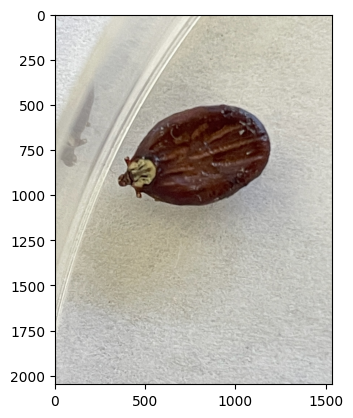

Dermacentor Variabilis
Certainty: 98.21392893791199%


In [7]:
# Run model prediction on image 

def load(filename):
    """Converts an image file to a numpy array"""
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (256,256,3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

image = 'testing/000001.jpg'
image_load = load(image)
# result is a 4 item list nested in a list 
result = model.predict(image_load) 
# access the nested list 
result = result[0]
# map each value in the results list to a species class confidence  
preds = {
    "Amblyomma Americanum": result[0], 
    "Dermacentor Variabilis": result[1],
    "Ixodes Scapularis": result[2],
    "Non-tick": result[3]
}
# read image for display
img = mpimg.imread(image)
# plot image 
imgplot = plt.imshow(img)
plt.show()
# select the item in preds that has the highest confidence
prediction = max(preds, key=preds.get)
print(prediction)
print('Certainty:', str(preds[prediction]*100)+'%')

Model Performance Analysis 